<a href="https://colab.research.google.com/github/ahmed-boutar/adverserial-patch/blob/main/adversial_patch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will be generating an Adversarial Patch, in order to fool the RES34 model and have it classify different images to which the patch was added, with a wrong label.
The code in this notebook was largely referenced from this colab notefbook, produced by Phillip Lippe. Source: https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb#scrollTo=y3loTwApmeNx

The difference here is using a image mask in the training in order to produce stickers and not just a rectangular image.

In [9]:
# # Please use this to connect your GitHub repository to your Google Colab notebook
# # Connects to any needed files from GitHub and Google Drive
# import os

# # Remove Colab default sample_data
# !rm -r ./sample_data

# # Clone GitHub files to colab workspace
# repo_name = "ahmed-boutar" # Change to your repo name
# git_path = 'https://github.com/ahmed-boutar/adverserial-patch.git' #Change to your path
# !git clone "{git_path}"

# # Install dependencies from requirements.txt file
# %!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# # Change working directory to location of notebook
# notebook_dir = 'src'
# path_to_notebook = os.path.join(repo_name,notebook_dir)
# %cd "{path_to_notebook}"
# %ls

Importing standard libraries and choosing the device

In [10]:
## Standard libraries
import os
import json
import math
import time
import numpy as np 
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set_theme()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# Pillow (to be used later for saving the patches as png files)
from PIL import Image

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print("Using device", device)

/var/folders/b7/2dqsctv50sbgk3bg9gpz453c0000gn/T/ipykernel_4240/3204026054.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Global seed set to 42


Using device mps


Download the dataset TinyImageNet, which is a subset of the ImageNet dataset. The dataset has been preprocessed and won't require resizing the different images. 
Download the pretrained res34 model (trained on TinyImageNet dataset)

In [11]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

use common CNN architectures trained on the ImageNet dataset. Such models are luckily provided by PyTorch's torchvision package, and hence we just need to load the model of our preference.

In [12]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Loading the data (from TinyImageNet, a subset of ImageNet under the same license) and creating a data loader. 

In [13]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)
    
def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

"The function below plots an image along with a bar diagram of its predictions. We also prepare it to show adversarial examples for later applications"

In [16]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):
    
    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()
    
    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})
    
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')
    
    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1 
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')
    
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')
    
    plt.show()
    plt.close()

Visualize a few images

/Users/ahmedboutar/Desktop/Duke/Fall2024/AIPI590/assignment-2/adverserial-patch/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ahmedboutar/Desktop/Duke/Fall2024/AIPI590/assignment-2/adverserial-patch/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ahmedboutar/Desktop/Duke/Fall2024/AIPI590/assignment-2/adverserial-patch/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ahmedbout

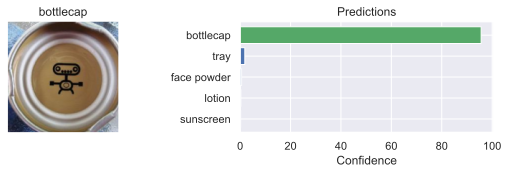

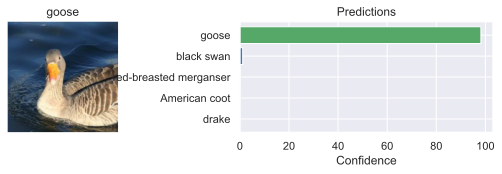

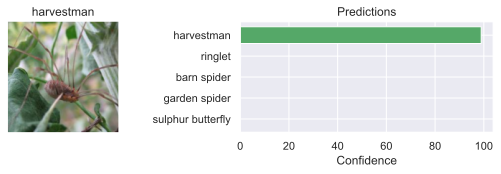

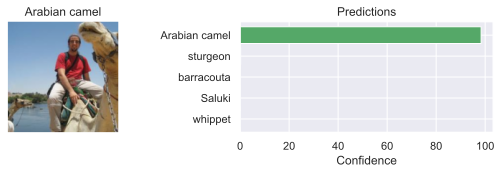

In [17]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

In [177]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
        
    return img

The patch itself will be an nn.Parameter whose values are in the range between  −∞  and  ∞ . Images are, however, naturally limited in their range, and thus we write a small function that maps the parameter into the image value range of ImageNet

In [178]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    global TENSOR_MEANS, TENSOR_STD
    # Ensure TENSOR_MEANS and TENSOR_STD are on the correct device
    TENSOR_MEANS = TENSOR_MEANS.to(device)
    TENSOR_STD = TENSOR_STD.to(device)
    # Ensure patch is on the correct device
    patch = patch.to(device)
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

"Before looking at the actual training code, we can write a small evaluation function. We evaluate the success of a patch by how many times we were able to fool the network into predicting our target class. A simple function for this is implemented below"

In [20]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4): 
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

We define a function that will create a circular mask that will be placed on the image during training in order to produce a rounded patch (a sticker)

In [171]:
def create_circular_mask(h, w, device, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device))
    dist_from_center = torch.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask.float()

In [182]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)
    
    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1], device=device), requires_grad=True)
    mask = create_circular_mask(patch_size[0], patch_size[1], device)

    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()
    
    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = img.to(device)
            #apply circular mask to the patch
            masked_patch = patch * mask

            #place the masked patch on the image
            patched_img = place_patch(img.clone(), masked_patch)

            pred = model(patched_img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")
    
    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)
    
    return patch.data, {"acc": acc.item(), "top5": top5.item()}, mask.data

To get some experience with what to expect from an adversarial patch attack, we want to train multiple patches for different classes. As the training of a patch can take one or two minutes on a GPU, we have provided a couple of pre-trained patches including their results on the full dataset. The results are saved in a JSON file, which is loaded below.

In [22]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)
        
# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t 
                                   for t in patch_dict[cname][psize]["results"]] 
                           for psize in patch_dict[cname]} 
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

Create a new folder where generated_patches will be saved

In [23]:
PATCHES_PATH = os.path.join(CHECKPOINT_PATH, "generated_patches")
os.makedirs(PATCHES_PATH, exist_ok=True)

This function will be used to save a png image of the patch for visualization purposes and to use on the streamlit app available to test the RES34 model

Note that this function saves the patch with the mask still on it, meaning that it will be a png with the outer section being a circle. We will later use a function that deletes the mask and finally saves the result as a circular image (a sticker)

In [202]:
def convert_patch_to_img(patch):
    patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
    img = patch.cpu().permute(1, 2, 0).numpy()
    img = np.clip(img, a_min=0.0, a_max=1.0)
    return img

def save_patch_png(name, patch_size, patch_dict):
    img = convert_patch_to_img(patch_dict[name][patch_size]['patch'])
    file_name_as_png = os.path.join(PATCHES_PATH, f"{name}_{patch_size}_patch.png")
    # Convert the img numpy array to the range [0, 255] and to uint8 type
    img_uint8 = (img * 255).astype(np.uint8)
    # Create a PIL image from the numpy array
    img_pil = Image.fromarray(img_uint8)
    # Save the image as a PNG file
    img_pil.save(file_name_as_png)


This function trains call initializes the training of new patches or retrieves data from patches previously trained, depending on whether or not the patch name exists

In [199]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()
    
    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(PATCHES_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results, mask = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=15)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)    
            
            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch,
                "mask": mask
            }
        
    return result_dict

In [ ]:
class_names = ['paper towel', 'bulletproof vest']
patch_sizes = [32, 48, 64, 128]

patch_dict = get_patches(class_names, patch_sizes)
save_results(patch_dict)

In [206]:
save_results(patch_dict)

This function will save the patch as a circular image, where the mask is made transparent. 
The cell below also calls a function that saves all the generated patches in the dictionary created above to a png (rectangle version of the patch and a circular one, which corresponds to a sticker)

In [211]:
from PIL import Image
def save_circular_patch(name, patch_size, patch_dict):
    file_name_as_png = os.path.join(PATCHES_PATH, f"{name}_{patch_size}_patch_sticker.png")

    # Ensure patch and mask are on CPU and in the correct format
    patch = patch_dict[name][patch_size]['patch'].cpu().detach().numpy()
    mask = patch_dict[name][patch_size]['mask'].cpu().detach().numpy()

    # Transpose to (H, W, C) format for image processing
    patch = np.transpose(patch, (1, 2, 0))

    # Normalize patch values to [0, 1] range
    patch = (patch - patch.min()) / (patch.max() - patch.min())

    # Create an RGBA image (Red, Green, Blue, Alpha)
    rgba = np.zeros((patch.shape[0], patch.shape[1], 4))
    rgba[:,:,:3] = patch
    rgba[:,:,3] = mask  # Use the mask for the alpha channel

    # Create a PIL Image from the RGBA array
    img = Image.fromarray((rgba * 255).astype(np.uint8))
    
    # Save the image
    img.save(file_name_as_png, 'PNG')

def save_patches_in_different_formats(class_names, patch_sizes, patch_dict):
    for name in class_names:
        for patch_size in patch_sizes:
            save_patch_png(name, patch_size, patch_dict)
            save_circular_patch(name, patch_size, patch_dict)

save_patches_in_different_formats(class_names, patch_sizes, patch_dict)

In [ ]:
def show_patches():
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
show_patches()

In [193]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

Function that outputs a table in order to display the accuracy of the different patches and their different sizes 

In [194]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f"{(100.0 * patch_dict[name][psize]['results'][i]):4.2f}%" for psize in patch_sizes]
             for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

In [195]:
show_table(top_1=True)

Class name,Patch size 64x64
bulletproof vest,90.77%


In [196]:
show_table(top_1=False)

Class name,Patch size 64x64
bulletproof vest,98.47%


This function performs the patch attack by placing the patch on different images and seeing how the patch performs, by looking at the top 5 labels the model predicted

In [191]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

In [ ]:
#perform_patch_attack(patch_dict['bulletproof vest'][32]['patch'])

In [217]:
perform_patch_attack(patch_dict['paper towel'][128]['patch'])

IndexError: tuple index out of range

In this notebook, I created an adversarial patch of different sizes in order to fool the RES34 model. If the input img contains the patch, then the model would label it as 'paper towel'. 

During training epoch was set to 15, meaning for every size, the patch will go through 15 iterations of training. The result increased the accuracy (even though for smaller values of epoch, the accuracy was still quite high). Changing the optimizer to Adam did not affect the accuracy a lot. From what I have seen, using the SGD was better, although I haven't tweaked the parameters of each optimizer that much, given the time it takes to generate patches. 